<a href="https://colab.research.google.com/github/Kennedy87670/NLP/blob/main/Skimlit_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: SkimLit

In [1]:
#confirm GPU
#!nvidia-smi

# getting the data
 the data is goten from: https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# check what files are in the publised Pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, its time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize Visualize Visualize

so with that in mind, lets write a fuction to read all of the lines of a target text file

In [6]:
# create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: a string containing the target filepath.

  Returns:
  Alist of strings with one string per line for the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# lets read in the training lines
train_lines = get_lines(data_dir+ "train.txt") # read the lines within
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

# lets think about how we want our data to look....

#How i think our data would be best created 

[ {'line_number':0,
   'target': 'BACKGROUND',
   "text": 'Emotional eating is associated with overeating and the development of obesity .\n',
   "total_lines": 11},
    ...]
 format

Lets write a function which turns each of our datasets into the above format so we can continue to prepare

In [8]:


def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 624 ms, sys: 160 ms, total: 784 ms
Wall time: 970 ms


(180040, 30212, 30135)

In [10]:
# check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a Datafram to futher visualize

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df =pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

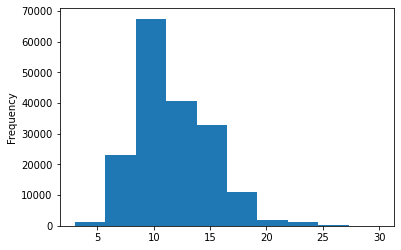

In [13]:
# lets check the length of different lines
train_df.total_lines.plot.hist()

# Get the list of sentences

In [14]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [15]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [16]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
#c check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label Encode labels

In [17]:
# Extract labels ('target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments...

As usual, we are going to be trying out a bunch of different models and seeing which one works best.

And as always, we are going to start with a baseline (TF-IDF Multinomial Naive Bays Classifier)

In [19]:
## Model 0: Getting a baseline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [20]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

# Download our helper function

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-29 10:49:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-29 10:49:56 (99.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

In [24]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred =baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [25]:
import numpy as np
from tensorflow.keras import layers

In [26]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([3.6293e+04, 7.6251e+04, 4.4193e+04, 1.4273e+04, 5.4860e+03,
        1.9400e+03, 8.5400e+02, 3.9100e+02, 1.7400e+02, 8.4000e+01,
        3.7000e+01, 1.9000e+01, 1.3000e+01, 5.0000e+00, 1.1000e+01,
        8.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00]),
 array([  1.        ,  14.40909091,  27.81818182,  41.22727273,
         54.63636364,  68.04545455,  81.45454545,  94.86363636,
        108.27272727, 121.68181818, 135.09090909, 148.5       ,
        161.90909091, 175.31818182, 188.72727273, 202.13636364,
        215.54545455, 228.95454545, 242.36363636, 255.77272727,
        269.18181818, 282.59090909, 296.        ]),
 <a list of 22 Patch objects>)

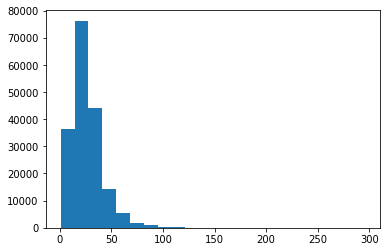

In [27]:
# whats the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=22)

In [28]:
# How long of the sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:

# Maximum sequence length in the training set
max(sent_lens)

296

import numbers
## Create text vectorization layer

We want to make a layer which maps our text from words to numbers

In [30]:
# How many words are in our vocab? 
max_tokens = 68000

In [31]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length= output_seq_len)  # desired output lenth of vectorized sequences

In [32]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the aim of this prospective , randomized , single-centre study was to compare pulmonary vein isolation ( pvi ) only versus a left atrial maze ( lam ) procedure in patients with paroxysmal af during mitral valve surgery .

Length of text: 39

Vectorized text:
[[    2   267     4    23   241    29  4222    17    10     6   226   562
   1701  3600  4144   192   110     8   601   875 18417  5829   407     5
     12     7  3558   910    52  3774  1505   115     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Create text embedding

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True, #use masking to handel variable sequence length... remove all zeros
                               name="token_embedding") 



In [37]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the aim of this prospective , randomized , single-centre study was to compare pulmonary vein isolation ( pvi ) only versus a left atrial maze ( lam ) procedure in patients with paroxysmal af during mitral valve surgery .

Sentence after vectorization (before embedding):
[[    2   267     4    23   241    29  4222    17    10     6   226   562
   1701  3600  4144   192   110     8   601   875 18417  5829   407     5
     12     7  3558   910    52  3774  1505   115     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.00527619  0.0237051  -0.02586467 ...  0.02604361 -0.01947644
    0.04225681]
  [ 0.02928938  0.01972617 -0.04486446 ... -0.04304341  0.02943659
   -0.00281314]
  [ 0.014496   -0.03267938  0.00551239 ... -0.00387974  0.03644631
   -0.02685424]
  ...
  [ 0.03327211 -0.03719629 -0.01371826 ... -0.04531322 -0.01377537
    0.0

 ## Creating datasets (making sure our data loads as fast as possible)

 we are goint to setup our data to run as fast as possible with the tensorflow tf.data API, many of the steps are 

In [38]:
import tensorflow as tf


In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [43]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [44]:
# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
# Get summary of Conv1D model
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [46]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches


Epoch 1/3
562/562 [==============================] - 61s 105ms/step - loss: 0.9222 - accuracy: 0.6336 - val_loss: 0.6969 - val_accuracy: 0.7354
Epoch 2/3
562/562 [==============================] - 60s 107ms/step - loss: 0.6670 - accuracy: 0.7505 - val_loss: 0.6389 - val_accuracy: 0.7640
Epoch 3/3
562/562 [==============================] - 58s 103ms/step - loss: 0.6272 - accuracy: 0.7712 - val_loss: 0.6041 - val_accuracy: 0.7826


In [47]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)


945/945 [==============================] - 7s 7ms/step - loss: 0.6083 - accuracy: 0.7837


[0.6083431243896484, 0.783728301525116]

In [48]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.0963608e-01, 1.7337343e-01, 1.1907986e-01, 2.6625657e-01,
        3.1654019e-02],
       [4.6476996e-01, 2.5511244e-01, 9.6191112e-03, 2.6530638e-01,
        5.1921420e-03],
       [1.5641469e-01, 2.3848629e-02, 2.8717760e-03, 8.1679571e-01,
        6.9265960e-05],
       ...,
       [2.0011928e-06, 9.3895197e-04, 6.1714987e-04, 1.1232313e-06,
        9.9844080e-01],
       [5.8959544e-02, 4.4602472e-01, 1.1278208e-01, 7.5049847e-02,
        3.0718374e-01],
       [2.0899610e-01, 5.5844301e-01, 3.7724607e-02, 6.2888861e-02,
        1.3194743e-01]], dtype=float32)

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.37283198728981,
 'precision': 0.7802804755817128,
 'recall': 0.7837283198728981,
 'f1': 0.7813600045159704}

# Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained  word embeddings from https://tfhub.dev/google/universal-sentence-encoder/4

In [51]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [52]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
ninety-one children ( mean age @ years , m/f = @/@ ) were recruited of whom @ were accompanied by clowns .

Sentence after embedding:
[ 0.0151027  -0.00871481  0.05041059  0.02601449 -0.09765617  0.00614006
  0.00867364 -0.01155013 -0.09210353 -0.03715688  0.07574635  0.05258385
 -0.03330868  0.03034961  0.06600666 -0.06753095 -0.09296791 -0.03779408
 -0.04421122 -0.05033393  0.00439454  0.02095195 -0.01447146 -0.01301708
  0.01856389  0.00586988  0.04045326 -0.03721086  0.02263443  0.01527793] (truncated output)...

Length of sentence embedding:
512


## Building and fitting an NLP feature extraction model from TF HUB


In [54]:

# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                         name="MODEL_2_USE_feature_extractor")


# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Get a summary of the model
model_2.summary()

Model: "MODEL_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [56]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9173 - accuracy: 0.6510 - val_loss: 0.7982 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7699 - accuracy: 0.7013 - val_loss: 0.7567 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7535 - accuracy: 0.7127 - val_loss: 0.7417 - val_accuracy: 0.7131


In [57]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7427 - accuracy: 0.7133


[0.742740273475647, 0.7132927179336548]

In [58]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.5057404e-01, 3.5782012e-01, 2.1575915e-03, 1.8179479e-01,
        7.6535479e-03],
       [3.2229272e-01, 5.2406406e-01, 4.4424087e-03, 1.4554343e-01,
        3.6573983e-03],
       [2.3128955e-01, 1.7864375e-01, 1.7537750e-02, 5.3338629e-01,
        3.9142720e-02],
       ...,
       [2.1492254e-03, 6.5588411e-03, 5.1440604e-02, 9.1219065e-04,
        9.3893915e-01],
       [4.0170043e-03, 4.2331621e-02, 2.0228972e-01, 1.3590232e-03,
        7.5000268e-01],
       [1.7091200e-01, 2.4982439e-01, 4.8899126e-01, 5.0856355e-03,
        8.5186660e-02]], dtype=float32)

In [59]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.32927313650205,
 'precision': 0.7139019716673426,
 'recall': 0.7132927313650205,
 'f1': 0.7102782388764846}

## Model 3: Conv1D with character embeddings

The paper which we are replicatng states they used a combination of token and character-level embeddings.

Previously we've token level embeddings but we will need to do similar steps for charcters if we want to use char-level embeddings




In [61]:
### creating a cahracter leveltokenizer
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Mkae function to split sentences into characters
def split